## Flood Health Vulnerability (FHV) Assessment 2
This notebook analyzes Flood Health Vulnerability (FHV).

In [1]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
shape3 = shape3.drop(shape3.columns[[0,1,4,5,6,9,10,11,12,13,14,15]], axis=1)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# Division
shape1 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm1_bbs_20180410.shp')
# ------------------------------------------------- #

# District-level Population
df = pd.read_excel('./data/disaster_records/damagedata_DDM.xlsx', 
                   sheet_name='total_population',skiprows=0,skipfooter=0).fillna(0)
popu2017 = df[['ADM2_PCODE', 'Population']]

# Load Vulnerability
vuln = pd.read_hdf('./data/vuln_calculated_adm3.hdf')

## Join 2017 FFWC Flood Forecast and Inundation to Population data

In [2]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()                # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()    # Population Per Pixel (Decuple value)
# popu = (popu/popu.sum()*popu2017['Population'].sum()*10).astype(np.int16)        # Calibration
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1).flatten()  # Flood depth (decuple; unit is 10 cm)

In [3]:
# Affected population by Flood Inundation and Flood Forecast
# (a) Flood Inundation      # 1 (Perennial waterbodies), 2 (Flood inundation area)
# *Remove population not in both perennial water and flood inundation
popuInun = popu.copy()
popuInun[~np.isin(inun,[2])] = 0   
# (b) Flood Forecast        # Flood depth (decuple; unit is 10 cm)
# *Affected population increase linearly with flood depth by 3m
popuFcst = popu.copy(); thsd = 35                          
popuFcst[fcst <= thsd] =  popuFcst[fcst <= thsd]*(fcst[fcst <= thsd])**2/thsd**2
popuFcst[fcst < 10] = 0
popuFcst[fcst > 60000] = 0

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()

# Rescale from decuple to normal and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POP'], impact4['POPINUN'], impact4['POPFCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPINUNR'] = afftPopuInun/totlPopu
impact4['POPFCSTR'] = afftPopuFcst/totlPopu
# Aggregate to Upazila level
varlist = ['POP','POPINUN','POPFCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPINUNR'] = impact3['POPINUN']/impact3['POP']
impact3['POPFCSTR'] = impact3['POPFCST']/impact3['POP']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values

# Print
print('POPINUN: {:,}'.format(impact3['POPINUN'].sum().astype(int)))
print('POPFCST: {:,}'.format(impact3['POPFCST'].sum().astype(int)))

POPINUN: 19,642,620
POPFCST: 19,812,664


In [4]:
impact3['POP'].sum()

158489469.10000002

In [5]:
impact3

,,POP,POPINUN,POPFCST,POPINUNR,POPFCSTR,ADM2_PCODE,ADM2_EN
ADM3_PCODE,ADM3_EN,,,,,,,
100409,Amtali,263500.0,2535.8,18066.1,0.009624,0.068562,1004,Barguna
100419,Bamna,87846.1,388.9,2462.8,0.004427,0.028035,1004,Barguna
100428,Barguna Sadar,267990.9,1772.9,15834.1,0.006616,0.059084,1004,Barguna
100447,Betagi,111359.8,2369.1,20430.5,0.021274,0.183464,1004,Barguna
100485,Patharghata,165469.3,3718.8,14286.6,0.022474,0.086340,1004,Barguna
...,...,...,...,...,...,...,...,...
609141,Gowainghat,298516.6,52612.9,45687.7,0.176248,0.153049,6091,Sylhet
609153,Jaintiapur,232941.6,22366.9,12896.1,0.096019,0.055362,6091,Sylhet
609159,Kanaighat,324071.3,57873.0,44766.5,0.178581,0.138138,6091,Sylhet


## District-level averaged domain vulnerability, FHV, and affected population

In [6]:
# Affected popoulation in Upazila 
impact = impact3.reset_index().drop(['ADM2_PCODE','ADM2_EN','ADM3_EN'], axis=1)
impact['ADM3_PCODE'] = impact['ADM3_PCODE'].astype(int)
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
targ = (impact['ADM3_PCODE']/10000).astype(int) == 45
f45t30 = 300000 + impact.loc[targ, 'ADM3_PCODE'] % 10000
impact.loc[targ, 'ADM3_PCODE'] = f45t30.values
impact['ADM2_PCODE'] = (impact['ADM3_PCODE'] / 100).astype(int)
impact = impact.set_index('ADM3_PCODE')

# Merge vulnerability
merge3 = pd.merge(impact, vuln, how='outer', left_index=True, right_index=True)

# IMPACT ASSESSMENT -------------------------- #
# Multiplication (will be divided by district population)
# - Total population
merge3['EQUAL'] = merge3['POP']*merge3['equal']
merge3['EQUAL1'] = merge3['POP']*merge3['equal1']
merge3['EQUAL2'] = merge3['POP']*merge3['equal2']
merge3['EQUAL3'] = merge3['POP']*merge3['equal3']
merge3['PCA'] = merge3['POP']*merge3['pca']
merge3['PCA1'] = merge3['POP']*merge3['pca1']
merge3['PCA2'] = merge3['POP']*merge3['pca2']
merge3['PCA3'] = merge3['POP']*merge3['pca3']
# - Predicted affected population (forecast and inundation)
merge3['EQUALF'] = merge3['POPFCST']*merge3['equal']
merge3['EQUAL1F'] = merge3['POPFCST']*merge3['equal1']
merge3['EQUAL2F'] = merge3['POPFCST']*merge3['equal2']
merge3['EQUAL3F'] = merge3['POPFCST']*merge3['equal3']
merge3['EQUALI'] = merge3['POPINUN']*merge3['equal']
merge3['EQUAL1I'] = merge3['POPINUN']*merge3['equal1']
merge3['EQUAL2I'] = merge3['POPINUN']*merge3['equal2']
merge3['EQUAL3I'] = merge3['POPINUN']*merge3['equal3']
merge3['PCAF'] = merge3['POPFCST']*merge3['pca']
merge3['PCA1F'] = merge3['POPFCST']*merge3['pca1']
merge3['PCA2F'] = merge3['POPFCST']*merge3['pca2']
merge3['PCA3F'] = merge3['POPFCST']*merge3['pca3']
merge3['PCAI'] = merge3['POPINUN']*merge3['pca']
merge3['PCA1I'] = merge3['POPINUN']*merge3['pca1']
merge3['PCA2I'] = merge3['POPINUN']*merge3['pca2']
merge3['PCA3I'] = merge3['POPINUN']*merge3['pca3']
# District-level aggregation
cols = ['POPINUN','POPFCST',
        'EQUAL','EQUAL1','EQUAL2','EQUAL3',
        'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
        'EQUALI','EQUAL1I','EQUAL2I','EQUAL3I',
        'PCA','PCA1','PCA2','PCA3',
        'PCAF','PCA1F','PCA2F','PCA3F',
        'PCAI','PCA1I','PCA2I','PCA3I']
merge2 = merge3.groupby('ADM2_PCODE')[cols].sum().reset_index()
# - Import population
merge2 = pd.merge(popu2017, merge2, how='outer',on='ADM2_PCODE')
merge2 = merge2.rename(columns={'Population':'POP'}).set_index('ADM2_PCODE')
# - Calculation
merge2['EQUAL'] = merge2['EQUAL']/merge2['POP']
merge2['EQUAL1'] = merge2['EQUAL1']/merge2['POP']
merge2['EQUAL2'] = merge2['EQUAL2']/merge2['POP']
merge2['EQUAL3'] = merge2['EQUAL3']/merge2['POP']
merge2['EQUALF'] = merge2['EQUALF']/(merge2['POPFCST']+1)
merge2['EQUAL1F'] = merge2['EQUAL1F']/(merge2['POPFCST']+1)
merge2['EQUAL2F'] = merge2['EQUAL2F']/(merge2['POPFCST']+1)
merge2['EQUAL3F'] = merge2['EQUAL3F']/(merge2['POPFCST']+1)
merge2['EQUALI'] = merge2['EQUALI']/(merge2['POPINUN']+1)
merge2['EQUAL1I'] = merge2['EQUAL1I']/(merge2['POPINUN']+1)
merge2['EQUAL2I'] = merge2['EQUAL2I']/(merge2['POPINUN']+1)
merge2['EQUAL3I'] = merge2['EQUAL3I']/(merge2['POPINUN']+1)
merge2['PCA'] = merge2['PCA']/merge2['POP']
merge2['PCA1'] = merge2['PCA1']/merge2['POP']
merge2['PCA2'] = merge2['PCA2']/merge2['POP']
merge2['PCA3'] = merge2['PCA3']/merge2['POP']
merge2['PCAF'] = merge2['PCAF']/(merge2['POPFCST']+1)
merge2['PCA1F'] = merge2['PCA1F']/(merge2['POPFCST']+1)
merge2['PCA2F'] = merge2['PCA2F']/(merge2['POPFCST']+1)
merge2['PCA3F'] = merge2['PCA3F']/(merge2['POPFCST']+1)
merge2['PCAI'] = merge2['PCAI']/(merge2['POPINUN']+1)
merge2['PCA1I'] = merge2['PCA1I']/(merge2['POPINUN']+1)
merge2['PCA2I'] = merge2['PCA2I']/(merge2['POPINUN']+1)
merge2['PCA3I'] = merge2['PCA3I']/(merge2['POPINUN']+1)
merge2['POPINUNR'] = merge2['POPINUN']/merge2['POP']
merge2['POPFCSTR'] = merge2['POPFCST']/merge2['POP']
merge2['POPINUNM'] = merge2['POPINUN']/10**6
merge2['POPFCSTM'] = merge2['POPFCST']/10**6
# -------------------------------------------- #

# GeoDataFrame
merge3 = merge3.drop('ADM2_PCODE', axis=1)
mapdata3 = shape3.merge(merge3, how='outer', on='ADM3_PCODE')
mapdata2 = shape2.merge(merge2, how='outer', on='ADM2_PCODE')
mapdata2.to_file('./data/mapdata2.hdf')

### Percentage of population in FHV ranges

In [7]:
tpop = merge3['POP'].sum()
targ = merge3['equal'] >= 0.6
pvuln13 = merge3.loc[targ, 'POP'].sum()/tpop
targ = (merge3['equal'] < 0.6) & (merge3['equal'] >= 0.4)
pvuln12 = merge3.loc[targ, 'POP'].sum()/tpop
targ = (merge3['equal'] < 0.4)
pvuln11 = merge3.loc[targ, 'POP'].sum()/tpop
targ = merge3['pca'] >= 0.6
pvuln23 = merge3.loc[targ, 'POP'].sum()/tpop
targ = (merge3['pca'] < 0.6) & (merge3['equal'] >= 0.4)
pvuln22 = merge3.loc[targ, 'POP'].sum()/tpop
targ = (merge3['pca'] < 0.4)
pvuln21 = merge3.loc[targ, 'POP'].sum()/tpop
print('Percentage of population in FHV ranges\t\tEqual\tPCA')
print('High-Vuln (FHV >= 0.6):\t\t\t\t%.1f%%\t%.1f%%' % (pvuln13*100, pvuln23*100))
print('Moderate-Vuln (0.4 <= FHV < 0.6):\t\t%.1f%%\t%.1f%%' % (pvuln12*100, pvuln22*100))
print('Low-Vuln (FHV < 0.4):\t\t\t\t%.1f%%\t%.1f%%' % (pvuln11*100, pvuln21*100))

Percentage of population in FHV ranges		Equal	PCA
High-Vuln (FHV >= 0.6):				26.6%	25.4%
Moderate-Vuln (0.4 <= FHV < 0.6):		44.7%	46.4%
Low-Vuln (FHV < 0.4):				28.7%	29.8%


### Load 2017 flood damage records

In [53]:
# Load damage DataFrame
cols_drop = ['NDISPPOPU','DAMGROAD','NTRAUMA']
damage = pd.read_hdf('./data/impact.hdf',key='data').drop(cols_drop, axis=1)
damage_table = pd.read_hdf('./data/impact_table.hdf', key='table')
damage_table = damage_table.drop(index=damage_table[damage_table.Name.isin(cols_drop)].index, axis=0)
# Rescale using MinMax scaler (Do not scale 'PAFFCPOPU')
damage[damage.columns[1:]] = MinMaxScaler().fit_transform(damage[damage.columns[1:]])

# Merge Affected population and FHV with damage
cols = ['POP','POPFCST','POPINUN','POPFCSTR','POPINUNR','POPFCSTM','POPINUNM',
        'EQUAL','EQUAL1','EQUAL2','EQUAL3',
        'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
        'EQUALI','EQUAL1I','EQUAL2I','EQUAL3I',
        'PCA','PCA1','PCA2','PCA3',
        'PCAF','PCA1F','PCA2F','PCA3F',
        'PCAI','PCA1I','PCA2I','PCA3I']
result = pd.merge(merge2[cols], damage, how='inner', left_index=True, right_index=True).reset_index()
result = result.merge(shape2[['ADM2_EN','ADM2_PCODE','ADM1_EN','ADM1_PCODE']], how='inner', left_on='ADM2_PCODE',right_on='ADM2_PCODE')
result = result.set_index('ADM2_EN').reset_index()
# - Number of the reported affected population
result['POPREPO'] = result['PAFFCPOPU']*result['POP']
result['POPREPOM'] = result['POPREPO']/10**6

# Distress, Damage, Disruption, and Health
result['Distress'] = MinMaxScaler().fit_transform(result[['PAFFCPOPU','NDEATH']]).mean(1)
result['Damage'] = MinMaxScaler().fit_transform(result[['NDAMGHOUS','DAMGCLAND']]).mean(1)
result['Disruption'] = MinMaxScaler().fit_transform(result[['NAFFCINST','NDAMGTUBE']]).mean(1)
result['Health'] = MinMaxScaler().fit_transform(result[['NDIARRHEA','NODIEASE']]).mean(1)

# Reorder districts according to the division
result = result.sort_values('ADM1_PCODE')
result.to_hdf('./data/result.hdf', 'df')

### Table of correlation between FHV and domain vulnerability and post-disaster layers

In [9]:
# Temporary dataframe
temp = result[['Distress','Damage','Disruption','Health',
               'EQUAL','EQUAL1','EQUAL2','EQUAL3',
               'PCA','PCA1','PCA2','PCA3',
               'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
               'PCAF','PCA1F','PCA2F','PCA3F',
               'EQUALI','EQUAL1I','EQUAL2I','EQUAL3I',
               'PCAI','PCA1I','PCA2I','PCA3I'
              ]]
# Calculate correlation
corrmat = temp[temp.columns].corr(method=lambda x, y: pearsonr(x, y)[0]) - np.eye(len(temp.columns))
pvalmat = temp[temp.columns].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(temp.columns))
corrval = corrmat.round(2).copy()
# Add significance symbols
corrval[pvalmat <= 0.1] = corrval[pvalmat <= 0.1].applymap(lambda x: '{}*'.format(x))
corrval[pvalmat <= 0.05] = corrval[pvalmat <= 0.05].applymap(lambda x: '{}**'.format(x))
corrval[pvalmat <= 0.01] = corrval[pvalmat <= 0.01].applymap(lambda x: '{}***'.format(x))
# Change column name
left = corrval.loc[['EQUALF','EQUAL1F','EQUAL2F','EQUAL3F','EQUALI','EQUAL1I','EQUAL2I','EQUAL3I'],['Distress','Damage','Disruption','Health']]
right = corrval.loc[['PCAF','PCA1F','PCA2F','PCA3F','PCAI','PCA1I','PCA2I','PCA3I'],['Distress','Damage','Disruption','Health']]
val = np.hstack([left.values,right.values])
idx = pd.MultiIndex.from_product([['Forecast-based','Satellite-based'], ['SHV','Socio-econ','Health','Coping capacity']])
col = pd.MultiIndex.from_product([['Equal weight','PCA'], ['Distress','Damage','Disruption','Health']])
table = pd.DataFrame(index=idx, data=val,columns=col)
table

Equal weight                           \
                                    Distress Damage Disruption Health   
Forecast-based  SHV                     0.28  0.28*    0.33***  0.32*   
                Socio-econ           0.38***    0.2       0.3*   0.26   
                Health                  0.07   0.15       0.11   0.14   
                Coping capacity         0.19   0.27    0.34***  0.31*   
Satellite-based SHV                     0.26   0.27      0.32*  0.29*   
                Socio-econ           0.35***   0.17       0.26   0.17   
                Health                  0.06   0.14        0.1   0.14   
                Coping capacity         0.18   0.26    0.33***  0.29*   

                                     PCA                           
                                Distress Damage Disruption Health  
Forecast-based  SHV                 0.01   0.01        0.1   0.13  
                Socio-econ          -0.1  -0.21      -0.09   0.06  
                Health              0.04   0.11       0.07   0.03  
                Coping capacity     0.06   0.08       0.21   0.19  
Satellite-based SHV                -0.05  -0.05       0.04   0.08  
                Socio-econ          -0.2  -0.3*       -0.2  -0.06  
                Health              0.02   0.09       0.05   0.03  
                Coping capacity     0.05   0.06       0.19   0.17

### Barchart of FHV and damage

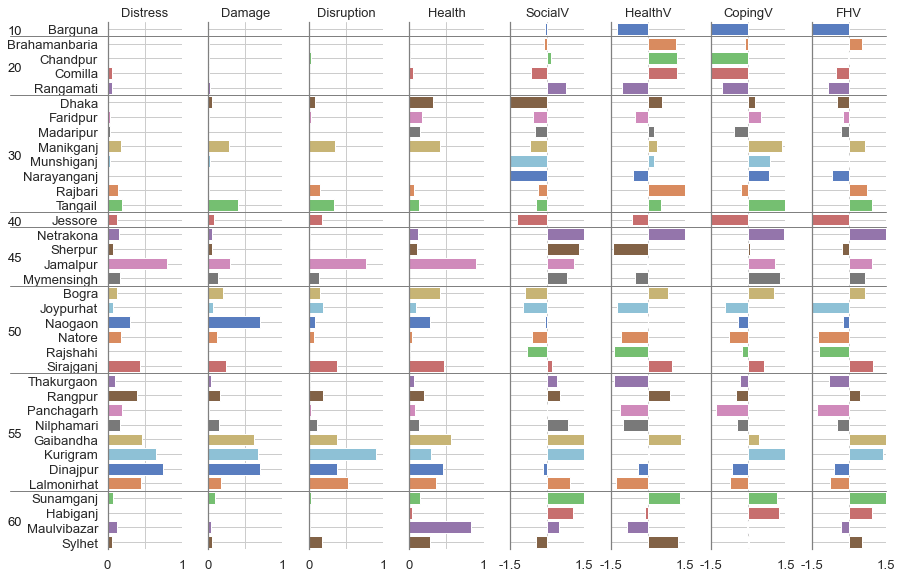

In [10]:
# Temporary dataframe
temp = result[['ADM1_PCODE','ADM2_EN',
               'Distress','Damage','Disruption','Health',
              'EQUAL1','EQUAL2','EQUAL3','EQUAL',
              ]]
temp = temp.rename(columns={'POPFCSTM':'Forecast','POPINUNM':'Satellite','POPREPOM':'Reported',
                            'NDEATH':'Death','NDAMGHOUS':'Houses','DAMGCLAND':'Land',
                            'NAFFCINST':'Institutions','NDAMGTUBE':'Tubewell',
                            'NDIARRHEA':'Diarrhea','NODIEASE':'Diseases',
                            'EQUAL1':'SocialV','EQUAL2':'HealthV','EQUAL3':'CopingV','EQUAL':'FHV',
                            'EQUAL1F':'eSocialF','EQUAL2F':'eHealthF','EQUAL3F':'eCopingF','EQUALF':'EQUALF',
                             })
cols_div = ['EQUAL','eSocial','eHealth','eCoping',
            'EQUALF','eSocialF','eHealthF','eCopingF',
            'PCA','pSocial','pHealth','pCoping',
            'SocialV','HealthV','CopingV','FHV']

# Standardization
std_true = 1
if std_true:
    temp[temp.columns[temp.columns.isin(cols_div)]] = StandardScaler().fit_transform(temp[temp.columns[temp.columns.isin(cols_div)]])

# PairGrid plots
sns.set(style="white", font_scale=1.2)
g = sns.PairGrid(temp, x_vars=temp.columns[2:], y_vars=['ADM2_EN'], height=8, aspect=.20)
g.map(sns.barplot, palette='muted')

# Title, axis, and grids
g.set(xlabel='',ylabel='', yticklabels=temp['ADM2_EN'])
for ax, title in zip(g.axes.flat, temp.columns[2:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')
    if std_true:
        if ~np.isin(title, cols_div):
            ax.set_xlim(0,1)
            ax.set_xticks([0,0.5,1])
            ax.set_xticklabels([0, '', 1])
        else:
            ax.set_xlim(-1.5,1.5)
            ax.set_xticks([-1.5,0,1.5])
            ax.set_xticklabels(['-1.5', '', '1.5'])
    else:
            ax.set_xlim(0,1)
            ax.set_xticks([0,0.5,1])
            ax.set_xticklabels([0, '', 1])

# Division lines and names
divs = temp['ADM1_PCODE'].tolist()
for i, div in enumerate(divs):
    if i and div != divs[i - 1]:
        # Division line
        g.axes.flat[-1].axhline(i-0.5, xmin=-len(temp.columns[2:])-2.8, 
                                xmax=1, c='#808080FF', lw=1, clip_on=False)
    if div != divs[i - 1]:
        # Division name
        lx = np.arange(len(temp['ADM1_PCODE']))[np.isin(divs, div)]
        g.axes.flat[0].annotate(div, [-1.25, np.median(lx)+0.15], 
                    annotation_clip=False, xycoords='data',
                    color='k', ha='center', va='center',fontfamily='sans-serif', fontsize=13)

# Remove axis lines
sns.despine(left=False, bottom=True);plt.tight_layout(pad=0.4);plt.show()

# Save a figure
if False:
    fn_save = './figures/chart_impact.png'
    g.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### Barchart of the number of affected population (Forecast, Satellite, and Reported)

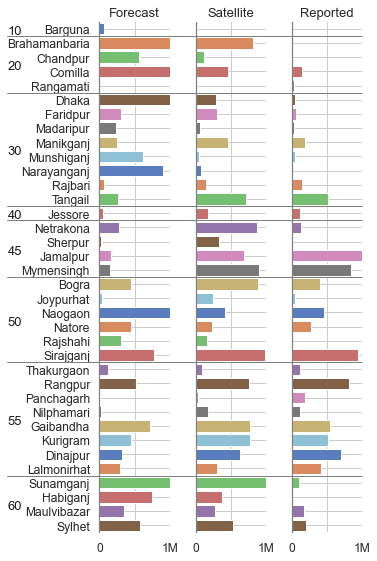

In [11]:
# Temporary dataframe
temp = result[['ADM1_PCODE','ADM2_EN','POPFCSTM','POPINUNM','POPREPOM']]
temp = temp.rename(columns={'POPFCSTM':'Forecast','POPINUNM':'Satellite','POPREPOM':'Reported'})

# Plotting setting
sns.set(style="white", font_scale=1.1)
g = sns.PairGrid(temp, x_vars=temp.columns[2:], y_vars=['ADM2_EN'], height=8, aspect=.25)
g.map(sns.barplot, palette='muted')
g.set(xlim=[0, 1], xticks=[0,0.5,1], xticklabels=[0, '', '1M'], xlabel='', 
      ylabel='', yticklabels=temp['ADM2_EN'])
# Column name and Grids
for ax, title in zip(g.axes.flat, temp.columns[2:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')

# Division lines and names
divs = temp['ADM1_PCODE'].tolist()
for i, div in enumerate(divs):
    if i and div != divs[i - 1]:
        # Division line
        g.axes.flat[-1].axhline(i-0.5, xmin=-4.05, xmax=1, c='#808080FF', lw=1, clip_on=False)
    if div != divs[i - 1]:
        # Division name
        lx = np.arange(len(temp['ADM1_PCODE']))[np.isin(divs, div)]
        g.axes.flat[0].annotate(div, [-1.2, np.median(lx)+0.15], 
                    annotation_clip=False, xycoords='data',
                    color='k', ha='center', va='center',fontfamily='sans-serif', fontsize=13)
            
# Remove axis lines
sns.despine(left=False, bottom=True);plt.tight_layout();plt.show()

# Save a figure
if False:
    fn_save = './figures/affected_popu_chart.png'
    g.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

## Mapping the results

### (a1) Percentage of affected population (Forecast and Inundation)

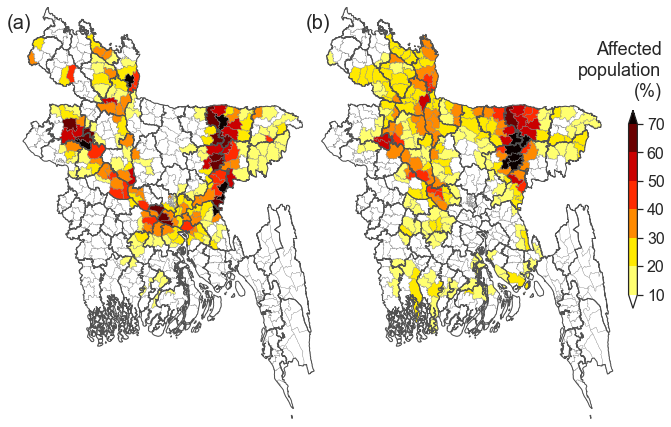

./figures/affected_popu_upazila_large.png is saved.


In [12]:
# Colormap
bounds = list(np.arange(0.1,0.71,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Affected\npopulation\n(%)'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['POPFCSTR','POPINUNR']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata3.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                  linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    
    # Borderline of ADM1
    shape2.boundary.plot(ax=ax, linewidth=1, edgecolor='#525252')
#     shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.f'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=16)
cbar.ax.annotate(figlabel, xy=(3.75, 1.2), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=18)    
plt.show()

# Save a figure
if True:
    fn_save = './figures/affected_popu_upazila_large.png'
    fig.savefig(fn_save, bbox_inches='tight',dpi=200); print('%s is saved.' % fn_save)

### (a2) Percentage of affected population (Forecast, Inundation, and Reported)

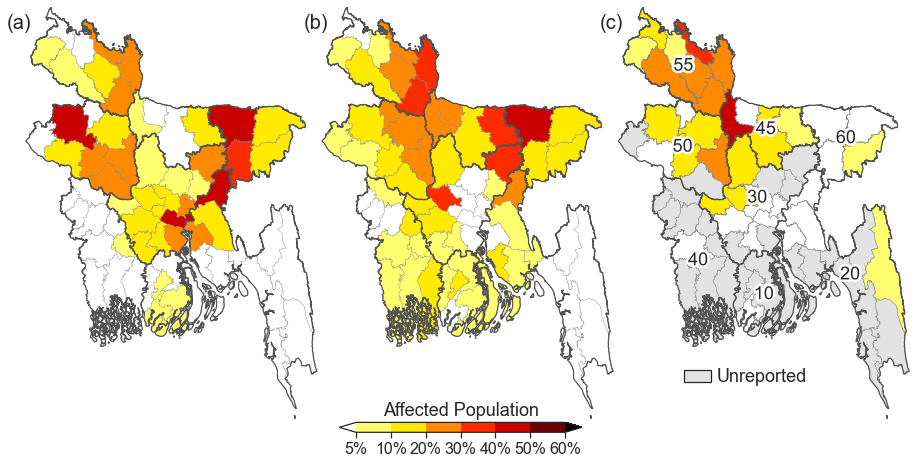

./figures/affected_popu_district_large.png is saved.


In [13]:
# Import reported percentage of affected population
afftpopu = pd.read_hdf('./data/impact.hdf',key='data').reset_index()[['ADM2_PCODE','PAFFCPOPU']]
# mapdata = mapdata2.merge(afftpopu,how='outer',left_on='ADM2_PCODE',right_on='ADM2_PCODE').fillna(0)
mapdata = mapdata2.merge(afftpopu,how='outer',left_on='ADM2_PCODE',right_on='ADM2_PCODE')
mapdata[['POPFCSTR','POPINUNR','PAFFCPOPU']] = mapdata[['POPFCSTR','POPINUNR','PAFFCPOPU']].fillna(0).values
unreported = mapdata[~np.isin(mapdata['ADM2_PCODE'], result['ADM2_PCODE'])]

# Colormap
bounds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)']
figlabel = 'Affected Population'
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,5), facecolor='w')
for (i, el) in enumerate(['POPFCSTR','POPINUNR','PAFFCPOPU']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata.plot(ax=ax, column=el, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.02, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    if i == 2:
        # Unreported districts
        unreported.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
        mapdata.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='grey')
        # Labels of ADM1_PCODE
        shape1.apply(lambda x: ax.annotate(text=x.ADM1_PCODE, xy=x.geometry.centroid.coords[0], 
                                           ha='center',va='center',fontsize=18, fontname='arial',
                                           path_effects=[pe.withStroke(linewidth=5, foreground="white")]),axis=1)
    # Borderline of ADM1
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)

# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.95, -0.03, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.f%%'%lb for lb in np.array(bounds)*100], 
                        fontname='arial', fontsize=16)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=18, 
               horizontalalignment='center')

# Colorbar for the unreported districts
cax2 = inset_axes(ax, width="46%", height="3.5%", bbox_to_anchor=(0.12, -0.68, 0.2, 0.8),bbox_transform=ax.transAxes,borderpad=0)
cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap=ListedColormap('#E2E2E2'),ticks=[], orientation='horizontal')
cbar2.ax.text(1.2,0,'Unreported',fontname='arial', fontsize=18)
plt.show()

# Save a figure
if True:
    fn_save = './figures/affected_popu_district_large.png'
    fig.savefig(fn_save, bbox_inches='tight', dpi=150)
    print('%s is saved.' % fn_save)

In [14]:
mapdata2.merge(afftpopu,how='outer',left_on='ADM2_PCODE',right_on='ADM2_PCODE').dtypes

ADM2_EN         object
ADM2_PCODE       int64
ADM1_EN         object
ADM1_PCODE      object
geometry      geometry
POP              int64
POPINUN        float64
POPFCST        float64
EQUAL          float64
EQUAL1         float64
EQUAL2         float64
EQUAL3         float64
EQUALF         float64
EQUAL1F        float64
EQUAL2F        float64
EQUAL3F        float64
EQUALI         float64
EQUAL1I        float64
EQUAL2I        float64
EQUAL3I        float64
PCA            float64
PCA1           float64
PCA2           float64
PCA3           float64
PCAF           float64
PCA1F          float64
PCA2F          float64
PCA3F          float64
PCAI           float64
PCA1I          float64
PCA2I          float64
PCA3I          float64
POPINUNR       float64
POPFCSTR       float64
POPINUNM       float64
POPFCSTM       float64
PAFFCPOPU      float64
dtype: object

### District-level Average FHV of Affected Population

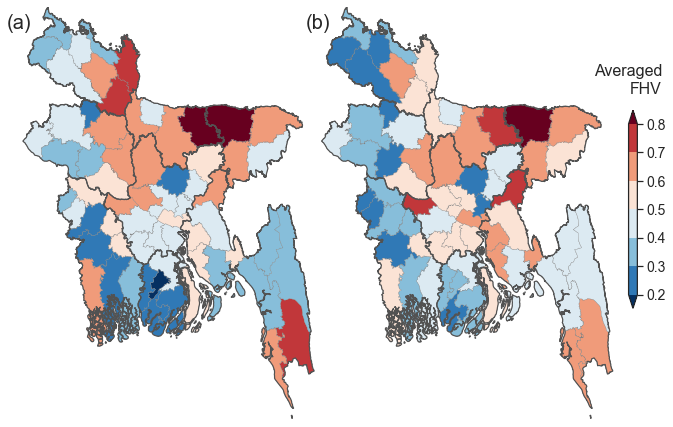

In [15]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)']
figlabel = 'Averaged\nFHV'
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(8,5), facecolor='w')
for (i, el) in enumerate(['EQUAL','PCA']):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata2.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    # Borderline of ADM1
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="5%", height="40%",
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0.27, 0.6, 1.2),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='vertical')
cbar.ax.set_yticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.ax.annotate(figlabel, xy=(3.8, 1.15), xycoords='axes fraction',
                horizontalalignment='right', verticalalignment='center',
                fontname='arial',fontsize=16)    
plt.show()

# Save a figure
if False:
    fn_save = './figures/avg_fhv_district.png'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

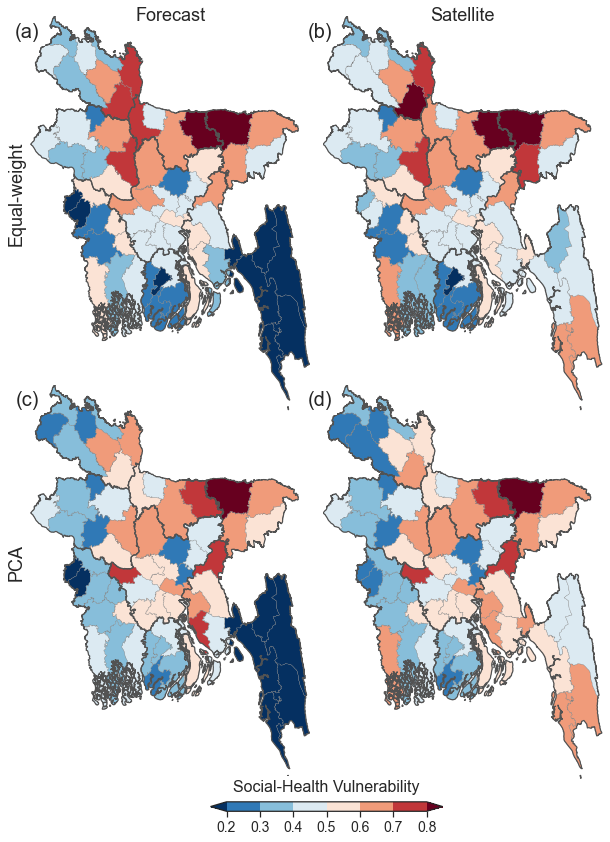

./figures/fhv_district_large.png is saved.
./figures/fhv_district.pdf is saved.


In [17]:
# Colormap
bounds = list(np.arange(0.2,0.8,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)','(b)','(c)','(d)']
figlabel = 'Social-Health Vulnerability'
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(8,10), facecolor='w')
for (i, el) in enumerate(['EQUALF','EQUALI','PCAF','PCAI']):
    ax = axes.flatten('C')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    mapdata2.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.01, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20, backgroundcolor='w')
    # Borderline of ADM1
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
    # Row and Column annotation
    if i == 0:
        ax.annotate('Equal-weight', xy=(-0.05, 0.55), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w", rotation=90)
        ax.annotate('Forecast', xy=(0.5, 1), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w")
    elif i == 1:
        ax.annotate('Satellite', xy=(0.5, 1), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w")
    elif i == 2:
        ax.annotate('PCA', xy=(-0.05, 0.55), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=18, backgroundcolor="w", rotation=90)
plt.tight_layout(pad=-2)
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(-0.40, -0.08, 1.8, 0.8),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.set_label(figlabel, labelpad=-55, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center', backgroundcolor='w')
plt.show()

# Save a figure
if True:
    fn_save = './figures/fhv_district_large.png'
    fig.savefig(fn_save, bbox_inches='tight', dpi=150); print('%s is saved.' % fn_save)
    fn_save = './figures/fhv_district.pdf'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

### Map of post-flood records layers

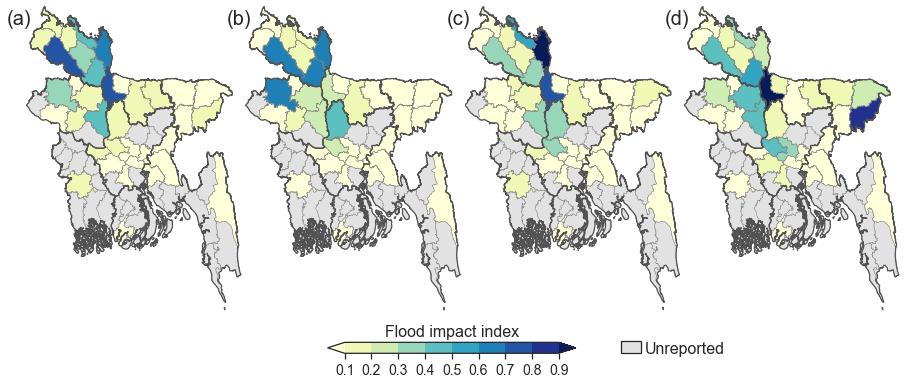

./figures/flood_impact_index_large.png is saved.
./figures/flood_impact_index.pdf is saved.


In [18]:
col_disaster = ['Distress','Damage','Disruption','Health']
map_disaster = shape2.merge(result[['ADM2_PCODE',*col_disaster]], how='outer', on='ADM2_PCODE')
map_disaster[col_disaster] = map_disaster[col_disaster].fillna(0).values
unreported = map_disaster[~np.isin(map_disaster['ADM2_PCODE'], result['ADM2_PCODE'])]

# Colormap
bounds = list(np.arange(0.1,1,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'YlGnBu', labloc='on',boundaries=boundaries, extension='both')

# Plotting
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
fignumb = ['(a)', '(b)', '(c)','(d)']
figlabel = 'Flood impact index'
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(12,5), facecolor='w')
for (i, el) in enumerate(col_disaster):
    ax = axes.flatten('F')[i]
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.axis(lims)
    map_disaster.plot(ax=ax, column=el,cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, 
                     linewidth=0.3, edgecolor='grey')
    ax.annotate(fignumb[i], xy=(-0.03, 0.96), xycoords='axes fraction',
                horizontalalignment='center', verticalalignment='center',
                fontname='arial',fontsize=20)
    # Unreported districts
    unreported.boundary.plot(ax=ax, facecolor='#E2E2E2',edgecolor='None')
    map_disaster.boundary.plot(ax=ax, facecolor='None', linewidth=0.3, edgecolor='grey')
    # Borderline of ADM1
    shape1.boundary.plot(ax=ax, linewidth=1.2, edgecolor='#525252')
    
plt.tight_layout(pad=-1)
# Colorbar
cax = inset_axes(ax, width="46%", height="4%",
                 loc='lower left',
                 bbox_to_anchor=(-1.65, -0.14, 2.5, 0.9),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=14)
cbar.set_label(figlabel, labelpad=-53, 
               fontname='arial', fontsize=16, 
               horizontalalignment='center')

# Colorbar for the unreported districts
cax2 = inset_axes(ax, width="46%", height="5%", bbox_to_anchor=(-0.4, -0.90, 0.2, 0.8),bbox_transform=ax.transAxes,borderpad=0)
cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap=ListedColormap('#E2E2E2'),ticks=[], orientation='horizontal')
cbar2.ax.text(1.2,0,'Unreported',fontname='arial', fontsize=16)
plt.show()

# Save a figure
if True:
    fn_save = './figures/flood_impact_index_large.png'
    fig.savefig(fn_save, bbox_inches='tight',dpi=150); print('%s is saved.' % fn_save)
    fn_save = './figures/flood_impact_index.pdf'
    fig.savefig(fn_save, bbox_inches='tight'); print('%s is saved.' % fn_save)

In [35]:
map_disaster

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,geometry,Distress,Damage,Disruption,Health
0,Bagerhat,4001,Khulna,40,"MULTIPOLYGON (((89.84021 21.82784, 89.84052 21...",0.000000,0.000000,0.000000,0.000000
1,Bandarban,2003,Chittagong,20,"POLYGON ((92.38065 22.33064, 92.38159 22.33002...",0.000000,0.000000,0.000000,0.000000
2,Barguna,1004,Barisal,10,"MULTIPOLYGON (((89.87968 22.07869, 89.87865 22...",0.000000,0.000000,0.000000,0.000000
3,Barisal,1006,Barisal,10,"MULTIPOLYGON (((90.55429 22.59271, 90.55435 22...",0.000000,0.000000,0.000000,0.000000
4,Bhola,1009,Barisal,10,"MULTIPOLYGON (((90.77172 21.85595, 90.76920 21...",0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
59,Sirajganj,5088,Rajshahi,50,"POLYGON ((89.68254 24.78337, 89.68266 24.78334...",0.434659,0.236098,0.376131,0.468548
60,Sunamganj,6090,Sylhet,60,"POLYGON ((91.27008 25.20512, 91.27091 25.20405...",0.072276,0.097229,0.035302,0.146109
61,Sylhet,6091,Sylhet,60,"POLYGON ((92.06496 25.18605, 92.06636 25.18556...",0.055293,0.048366,0.179210,0.283737
62,Tangail,3093,Dhaka,30,"POLYGON ((90.08191 24.78111, 90.08200 24.78093...",0.188570,0.406641,0.333177,0.136200


In [50]:

# Temporary dataframe
temp = result[['Distress','Damage','Disruption','Health',
               'EQUAL','EQUAL1','EQUAL2','EQUAL3',
               'PCA','PCA1','PCA2','PCA3',
               'EQUALF','EQUAL1F','EQUAL2F','EQUAL3F',
               'PCAF','PCA1F','PCA2F','PCA3F',
               'EQUALI','EQUAL1I','EQUAL2I','EQUAL3I',
               'PCAI','PCA1I','PCA2I','PCA3I'
              ]]
sns.scatterplot(temp, x="Distress", y="Damage")
plt.show()

/Users/dlee/opt/anaconda3/envs/dlee/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: Could not interpret value `Damage` for parameter `y`

In [37]:
temp

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,geometry,Distress,Damage,Disruption,Health
0,Barguna,1004,Barisal,10,"MULTIPOLYGON (((89.87968 22.07869, 89.87865 22...",0.000000,0.000000,0.000000,0.000000
1,Bogra,5010,Rajshahi,50,"POLYGON ((89.32932 25.12320, 89.32944 25.12319...",0.124583,0.200934,0.156182,0.405802
2,Brahamanbaria,2012,Chittagong,20,"POLYGON ((91.30884 24.26753, 91.30898 24.26747...",0.001388,0.005168,0.003517,0.000000
3,Chandpur,2013,Chittagong,20,"MULTIPOLYGON (((90.61238 23.01680, 90.61207 23...",0.002661,0.007177,0.024032,0.006747
4,Comilla,2019,Chittagong,20,"POLYGON ((91.03361 23.79557, 91.03372 23.79557...",0.060517,0.014264,0.000000,0.053191
5,Dhaka,3026,Dhaka,30,"POLYGON ((90.01730 24.04435, 90.01733 24.04426...",0.003680,0.048561,0.084408,0.323759
6,Dinajpur,5527,Rangpur,55,"POLYGON ((88.62406 26.05703, 88.62421 26.05692...",0.751520,0.693386,0.378114,0.454817
7,Faridpur,3029,Dhaka,30,"POLYGON ((89.82832 23.71169, 89.82854 23.71165...",0.030076,0.009271,0.027550,0.165938
8,Gaibandha,5532,Rangpur,55,"POLYGON ((89.53853 25.64087, 89.53864 25.64086...",0.460395,0.612103,0.377652,0.561732
9,Habiganj,6036,Sylhet,60,"MULTIPOLYGON (((91.30353 23.99673, 91.30344 23...",0.000000,0.000000,0.000000,0.035057
